In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, GRU, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.utils import to_categorical


2022-07-10 10:17:09.172852: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:

init_df = pd.read_csv('./csv/out_gameemo_time_domain_simple.csv',  sep=',')

print('Shape of data: ', init_df.shape)

Shape of data:  (4284224, 15)


In [3]:

df = init_df.copy()
print(df.head())

#HA_PV = high arousal, positive valence
#HA_NV = high arousal, negative valence
#LA_NV = low arousal, negative valence
#LA_PV = low arousal, positive valance

label_map = {1:"HA_PV", 2:"HA_NV", 3:"LA_NV", 4:"LA_PV"}

df["Label"] = df["Label"].map(label_map)


       AF3      AF4       F3       F4       F7       F8      FC5      FC6  \
0 -11.5692 -7.71280  13.0154 -7.71280  76.1643   9.1590  38.0819 -0.48193   
1 -12.5625 -6.52730  12.9572 -6.04490  76.1735  11.7427  35.5558 -0.69421   
2 -14.7008 -6.13520  12.6621 -4.71790  75.4600  13.9307  31.4947 -1.13450   
3  -7.3113 -2.63410  12.6253 -1.78380  83.2244  21.5305  29.8460  1.10270   
4  -2.2931 -0.78859  11.6270 -0.47166  89.5589  26.7464  26.8497  1.75970   

        O1      O2       P7       P8       T7       T8  Label  
0 -1.44630 -5.3026  0.48193 -10.1229  8.67710  5.30260    2.0  
1 -1.11830 -5.7076  0.69421  -9.7567  7.91530  3.77900    2.0  
2 -0.56926 -7.2934  0.65256 -11.0995  5.51220  0.17823    2.0  
3 -2.22230 -7.0967 -1.07380  -8.2644  3.49420  1.85480    2.0  
4 -5.70420 -7.8760 -4.62500  -7.0454  0.63323  1.98420    2.0  


In [4]:

print(df.head())

features = df.iloc[:, :-1]
label = df.iloc[:, -1:]

print('Shape of data: ', df.shape)
print('features.shape: ', features.shape)
print('label.shape: ', label.shape)

df.head()
print(df.columns)

y = label.to_numpy()
X = features.to_numpy()

# #normalize
# X = (X - np.min(X))/(np.max(X) - np.min(X))
# print("X max:", X.max(),"; mean:", X.min())
# print("X head:", X[0:10])

# 38252 is the max sample size, data collected for one participant. Can choose smaller sample size that can
# divide 38252.
# 38252 can be divided by 73 or 131, 524
sample_size = int(38252/73)  
num_of_features = 14

train_dataset_percentage = 0.7

print("sample_size:",sample_size)
print("num_of_features:",num_of_features)

total_samples_count = int(X.shape[0]/sample_size)

print("total_samples_count:", total_samples_count)


train_sample_count = int(total_samples_count * train_dataset_percentage)
test_sample_count = total_samples_count - train_sample_count

train_size = train_sample_count * sample_size
test_size = test_sample_count * sample_size

print("train size:", train_size)
print("test size:", test_size)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train = X_train.reshape((train_sample_count,sample_size,num_of_features))
X_test = X_test.reshape((test_sample_count,sample_size,num_of_features))

print("X_train.shape after reshape:",X_train.shape)
print("X_test.shape after reshape:",X_test.shape)

#collapse y_train and y_test to the same X sample counts instead

y_train_collapsed = np.array([])
for i in range(len(y_train)):
    if (i % sample_size == 0):
        y_train_collapsed = np.append(y_train_collapsed, (y_train[i]))
        
print("y_train_collapsed shape:",y_train_collapsed.shape)        

y_test_collapsed = np.array([])
for i in range(len(y_test)):
    if (i % sample_size == 0):
        y_test_collapsed = np.append(y_test_collapsed, (y_test[i]))
        
print("y_test_collapsed shape:",y_test_collapsed.shape)    


y_train = pd.get_dummies(y_train_collapsed)
y_test = pd.get_dummies(y_test_collapsed)

print("y_train.shape:", y_train.shape)
print("y_test.shape:", y_test.shape)



       AF3      AF4       F3       F4       F7       F8      FC5      FC6  \
0 -11.5692 -7.71280  13.0154 -7.71280  76.1643   9.1590  38.0819 -0.48193   
1 -12.5625 -6.52730  12.9572 -6.04490  76.1735  11.7427  35.5558 -0.69421   
2 -14.7008 -6.13520  12.6621 -4.71790  75.4600  13.9307  31.4947 -1.13450   
3  -7.3113 -2.63410  12.6253 -1.78380  83.2244  21.5305  29.8460  1.10270   
4  -2.2931 -0.78859  11.6270 -0.47166  89.5589  26.7464  26.8497  1.75970   

        O1      O2       P7       P8       T7       T8  Label  
0 -1.44630 -5.3026  0.48193 -10.1229  8.67710  5.30260  HA_NV  
1 -1.11830 -5.7076  0.69421  -9.7567  7.91530  3.77900  HA_NV  
2 -0.56926 -7.2934  0.65256 -11.0995  5.51220  0.17823  HA_NV  
3 -2.22230 -7.0967 -1.07380  -8.2644  3.49420  1.85480  HA_NV  
4 -5.70420 -7.8760 -4.62500  -7.0454  0.63323  1.98420  HA_NV  
Shape of data:  (4284224, 15)
features.shape:  (4284224, 14)
label.shape:  (4284224, 1)
Index(['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 

In [13]:


def plot_loss_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()

def plot_accuracy_history(history):
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['accuracy'] + 1)))
  plt.plot(history['accuracy'], label="training", marker='o')
  plt.plot(history['val_accuracy'], label="validation", marker='o')
  plt.legend()
  plt.show()


In [6]:
def train_model(x_train, y_train,x_test,y_test, save_to, epoch, sample_size, num_of_features):
    strategy = tf.distribute.MirroredStrategy(devices=None)
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))  
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)
    
    with strategy.scope():

#         inputs = tf.keras.Input(shape=(sample_size,num_of_features))
#         #ml_model = tf.keras.layers.GRU(256, return_sequences=True)(inputs)
#         ml_model = tf.keras.layers.LSTM(256, return_sequences=True)(inputs)
#         flat = Flatten()(ml_model)
#         outputs = Dense(4, activation='softmax')(flat)
#         model = tf.keras.Model(inputs, outputs)
        
        ######
        #sample size:38252/524, accuracy: 1.0000 - val_loss: 5.5889 - val_accuracy: 0.4403
        #sample size:38252/73, loss: 1.4733e-04 - accuracy: 1.0000 - val_loss: 4.6835 - val_accuracy: 0.5475
        model = Sequential()
        model.add(LSTM(256, return_sequences=True, input_shape=(sample_size,num_of_features)))

        model.add(Flatten())
        model.add(Dense(4))
        model.add(Activation('softmax'))        
        
        ######
#         model = Sequential()
#         model.add(LSTM(256, return_sequences=True, input_shape=(sample_size,num_of_features), go_backwards=True))
#         model.add(Flatten())
#         model.add(Dense(4))
#         model.add(Activation('softmax'))

        ######
        
#         model = Sequential()
#         model.add(Bidirectional(LSTM(256, return_sequences=True), 
#                                 input_shape=(sample_size,num_of_features))) #, merge_mode='concat'))
#         model.add(Flatten())
#         model.add(Dense(4))
#         model.add(Activation('softmax')) 
        

        model.summary()
        tf.keras.utils.plot_model(model)

        opt_adam = keras.optimizers.Adam(learning_rate=0.001)

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        mc = ModelCheckpoint(save_to + '_best_model_lstm_time_domain.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
            
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))
            
        model.compile(optimizer=opt_adam,
                      loss=['categorical_crossentropy'],
                      metrics=['accuracy'])

          
    history = model.fit(x_train,y_train,
                        batch_size=32,
                        epochs=epoch,
                        validation_data=(x_test,y_test),
                        callbacks=[es,mc,lr_schedule], shuffle=False)
        
    # saved_model = load_model(save_to + '_best_model_lstm_all_cat.h5')
        
    return model,history



In [15]:

model,history = train_model(X_train, y_train,X_test, y_test, save_to= './', epoch = 40, 
                            sample_size=sample_size, num_of_features=num_of_features)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 524, 256)          277504    
_________________________________________________________________
flatten (Flatten)            (None, 134144)            0         
_________________________________________________________________
dense (Dense)                (None, 4)                 536580    
_________________________________________________________________
activation (Activation)      (None, 4)                 0         
Total params: 814,084
Trainable params: 814,084
Non-trainable params: 0
_________________________________________________________________


2022-07-10 10:56:07.633746: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_13562"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.au

Epoch 1/40
179/179 [==============================] - ETA: 0s - loss: 12.7900 - accuracy: 0.2735

2022-07-10 10:57:38.744865: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_16525"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.au

179/179 [==============================] - 109s 591ms/step - loss: 12.7936 - accuracy: 0.2737 - val_loss: 14.8195 - val_accuracy: 0.1745

Epoch 00001: val_accuracy improved from -inf to 0.17448, saving model to ./_best_model_lstm_time_domain.h5
Epoch 2/40
179/179 [==============================] - 104s 582ms/step - loss: 4.5224 - accuracy: 0.5640 - val_loss: 12.8248 - val_accuracy: 0.3017

Epoch 00002: val_accuracy improved from 0.17448 to 0.30167, saving model to ./_best_model_lstm_time_domain.h5
Epoch 3/40
179/179 [==============================] - 104s 582ms/step - loss: 1.8549 - accuracy: 0.7785 - val_loss: 5.5924 - val_accuracy: 0.4868

Epoch 00003: val_accuracy improved from 0.30167 to 0.48675, saving model to ./_best_model_lstm_time_domain.h5
Epoch 4/40
179/179 [==============================] - 104s 582ms/step - loss: 0.1811 - accuracy: 0.9586 - val_loss: 4.4093 - val_accuracy: 0.5508

Epoch 00004: val_accuracy improved from 0.48675 to 0.55075, saving model to ./_best_model_lst

In [16]:
from matplotlib import pyplot as plt

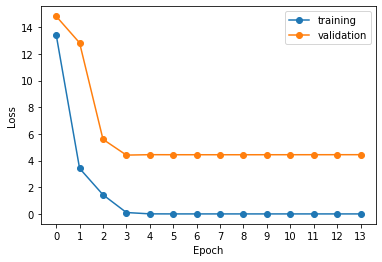

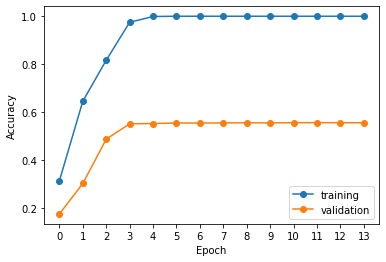

In [17]:

history = pd.DataFrame(history.history)
plot_loss_history(history)
plot_accuracy_history(history)